# Optimización codificación de imágenes en impusos (spikes)

En este Notebook realizamos las siguientes actividades:

1. Montaje de Google Drive y carga de datos: Montamos Google Drive, descomprimimos el archivo con las imágenes y cargamos los datos de conducción desde un archivo CSV. Simplificamos las rutas de las imágenes y categorizamos los ángulos de giro.

2. Equilibrio de datos: Equilibramos los datos de conducción replicando registros en categorías menos representadas y ajustamos la distribución de los ángulos de dirección para que sea más uniforme.

3. Carga de imágenes y división de datos: Asociamos cada imagen con un ángulo de giro ajustado y dividimos los datos en conjuntos de entrenamiento y validación.

4. Aplicación de aumentos de imagen: Desarrollamos funciones para aplicar aumentos de imagen (zoom, pan, brillo, sombra, etc.) de manera aleatoria y aseguramos que se mantiene una opción para no transformar la imagen, solo ajustando su tamaño.

5. Preprocesamiento de imágenes: Implementamos una función para preprocesar las imágenes, que incluye recorte, conversión de espacio de color, desenfoque gaussiano, redimensionamiento y normalización.

6. Codificación de imágenes en spikes: Modificamos el proceso de codificación de imágenes en spikes usando la modulación delta de snntorch. Agrupamos las imágenes en pares, aplicamos la codificación delta a cada par y asociamos el ángulo de la segunda imagen del par. Los resultados se almacenaron en tres tensores para los conjuntos de entrenamiento y validación.

7. Guardado de datos: Guardamos los conjuntos de datos codificados en archivos PyTorch y HDF5 y los copiamos a Google Drive.

## Carga y análisis del conjunto de datos

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descomprimir el archivo zip
%%capture
!unzip "/content/drive/MyDrive/UOC/TFM/Dataset/TrainImagesTFM_1_2.zip" -d "/content"

In [ ]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from imgaug import augmenters as iaa
import os

# Cargar datos de conducción desde un archivo CSV
def load_driving_data(csv_file_path):
    data = pd.read_csv(csv_file_path)
    data.columns = [
        'center_image', 'left_image', 'right_image',
        'steering_angle', 'throttle', 'brake', 'speed'
    ]
    return data

csv_file_path = '/content/TrainImagesTFM_1_2/driving_log.csv'
driving_data = load_driving_data(csv_file_path)
print(driving_data.head())

# Simplificar las rutas de las imágenes en el DataFrame
def simplify_image_path(dataframe, columns):
    for column in columns:
        dataframe[column] = dataframe[column].apply(lambda x: x.split('/')[-1])
    return dataframe

image_columns = ['center_image', 'left_image', 'right_image']
driving_data = simplify_image_path(driving_data, image_columns)
print(driving_data.head())

# Categorizar los ángulos de giro en el DataFrame
def categorize_turns(data, angle_column):
    bins = [-float('inf'), -0.1, 0.1, float('inf')]
    labels = ['Left Turn', 'Straight', 'Right Turn']
    data['turn_category'] = pd.cut(data[angle_column], bins=bins, labels=labels)
    turn_counts = data['turn_category'].value_counts()
    return turn_counts

turn_counts = categorize_turns(driving_data, 'steering_angle')
print(turn_counts)

# Equilibrar los datos replicando registros en categorías menos representadas
def balance_data_by_replication(data, category_column, target_size=None):
    categories = data[category_column].unique()
    subset_list = [data[data[category_column] == category] for category in categories]
    if not target_size:
        target_size = max(subset.shape[0] for subset in subset_list)
    balanced_subsets = [subset.sample(target_size, replace=True) if subset.shape[0] < target_size else subset for subset in subset_list]
    balanced_data = pd.concat(balanced_subsets, ignore_index=True)
    return balanced_data

balanced_driving_data = balance_data_by_replication(driving_data, 'turn_category')
print(balanced_driving_data['turn_category'].value_counts())

# Calcular el número máximo de muestras por bin basado en un percentil dado
def calculate_samples_per_bin(df, steering_col, num_bins, percentile):
    hist, _ = np.histogram(df[steering_col], bins=num_bins)
    max_samples = np.percentile(hist, percentile)
    return int(max_samples)

percentile = 90
num_bins = 25
max_samples_per_bin = calculate_samples_per_bin(balanced_driving_data, 'steering_angle', num_bins, percentile)
print("Número máximo de muestras por bin calculado:", max_samples_per_bin)

# Ajustar la distribución de los ángulos de dirección para que sea más uniforme
def remove_samples(df, num_bins=25, samples_per_bin=1500, steering_col='steering_angle'):
    df.reset_index(drop=True, inplace=True)
    hist, bins = np.histogram(df[steering_col], bins=num_bins)
    center = (bins[:-1] + bins[1:]) / 2
    remove_list = []
    for j in range(num_bins):
        list_indices = [i for i in range(len(df[steering_col])) if bins[j] <= df[steering_col].iloc[i] < bins[j + 1]]
        list_indices = shuffle(list_indices)
        list_indices = list_indices[samples_per_bin:]
        remove_list.extend(list_indices)
    df.drop(df.index[remove_list], inplace=True)
    return df

balanced_data_adjusted = remove_samples(balanced_driving_data)

# Asocia cada imagen de las cámaras central, izquierda y derecha con un ángulo de giro ajustado
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.2)
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.2)
    return np.array(image_path), np.array(steering)

offset_data_adjust = load_img_steering("/content/TrainImagesTFM_1_2/IMG/", balanced_data_adjusted)

# Crea datos de entrenamiento y validación
def trainValSample(dir, df):
    if not dir.endswith("/"):
        dir += "/"
    image_paths, steerings = load_img_steering(dir + "IMG/", df)
    X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)
    print("Training Samples: {}\nValidation Samples: {}".format(len(X_train), len(X_valid)))
    print("Total Samples: {}".format(len(image_paths)))
    return image_paths, steerings, X_train, X_valid, y_train, y_valid

image_paths, steerings, X_train, X_valid, y_train, y_valid = trainValSample("/content/TrainImagesTFM_1_2/", balanced_data_adjusted)

                                        center_image  \
0  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
1  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
2  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
3  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
4  /Users/fernandosevilla/UOC/UOC Repositorio asi...   

                                          left_image  \
0  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
1  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
2  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
3  /Users/fernandosevilla/UOC/UOC Repositorio asi...   
4  /Users/fernandosevilla/UOC/UOC Repositorio asi...   

                                         right_image  steering_angle  \
0  /Users/fernandosevilla/UOC/UOC Repositorio asi...             0.0   
1  /Users/fernandosevilla/UOC/UOC Repositorio asi...             0.0   
2  /Users/fernandosevilla/UOC/UOC Repositorio asi...             0.0   
3  /Users/fernandosevilla/UOC/UOC Repo

## Funciones de transformación, procesamiento y visualización

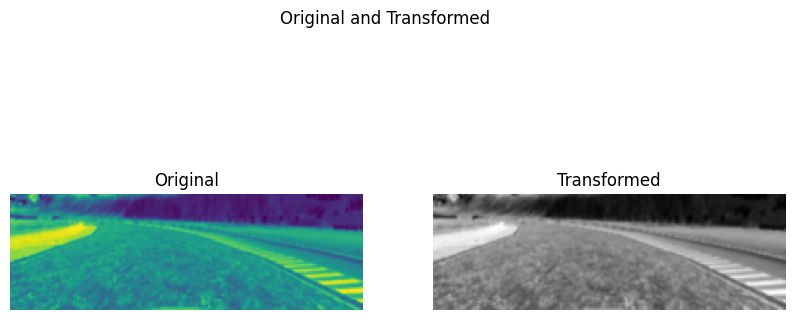

In [ ]:
import cv2
import numpy as np
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

# Funciones de aumento de imagen
def apply_zoom(image):
    zoom_transformer = iaa.Affine(scale=(1, 1.5))
    zoomed_image = zoom_transformer.augment_image(image)
    return zoomed_image

def random_flip(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    flipped_steering_angle = -steering_angle
    return flipped_image, flipped_steering_angle

def apply_pan(image):
    pan_transformer = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    panned_image = pan_transformer.augment_image(image)
    return panned_image

def apply_random_brightness(image):
    brightness_augmenter = iaa.Multiply((0.2, 1.6))
    brightened_image = brightness_augmenter.augment_image(image)
    return brightened_image

def apply_image_brighten(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = 0.25 + np.random.uniform()
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * brightness
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2], 0, 255)
    brightened_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return brightened_image

def apply_random_shadow(image):
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = image.shape
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
    mask = np.zeros_like(image[:, :, 1])
    mask[((ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1)) > 0] = 1
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2BGR)

# Función para aplicar aumentos aleatorios y ajustar el tamaño de la imagen
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = apply_pan(image)
    if np.random.rand() < 0.5:
        image = apply_zoom(image)
    if np.random.rand() < 0.5:
        image = apply_random_brightness(image)
    if np.random.rand() < 0.5:
        image = apply_image_brighten(image)
    if np.random.rand() < 0.5:
        image = apply_random_shadow(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

# Función para preprocesar la imagen para el entrenamiento del modelo CSNN
def img_preprocess(img):
    img = img[40:140, :, :]  # Recortar la imagen para eliminar características innecesarias
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Aplicar desenfoque gaussiano
    img = cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)  # Reducir el tamaño para facilitar el procesamiento
    img = (img - 128.) / 128.  # Normalizar los valores de los píxeles
    return img

# Ejemplo de uso con una imagen de prueba y su ángulo de dirección
image_path_example = "/content/TrainImagesTFM_1_2/IMG/center_2022_04_30_19_01_57_321.jpg"  # Ruta de ejemplo, reemplazar con una real
steering_angle_example = 0.0  # Ángulo de dirección de ejemplo

# Cargar la imagen
image = mpimg.imread(image_path_example)

# Aplicar aumentos aleatorios
augmented_image, adjusted_steering_angle = random_augment(image, steering_angle_example)

# Preprocesar la imagen aumentada
preprocessed_image = img_preprocess(augmented_image)

# Mostrar la imagen original y la aumentada
def compare_images(original, transformed, title='Original and Transformed'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(transformed, cmap='gray')
    axes[1].set_title('Transformed')
    axes[1].axis('off')

    plt.suptitle(title)
    plt.show()

compare_images(img_preprocess(image), preprocessed_image)


## Codificación en Impulsos

In [ ]:
# Instalar snntorch y torch
!pip install snntorch torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch
from snntorch import spikegen
import matplotlib.image as mpimg
import numpy as np
import os
import h5py
import shutil

# Función para convertir un valor a tensor
def value_to_tensor(value, tensor_length=21):
    value = round(value, 1)
    if value < -1 or value > 1:
        raise ValueError("El valor debe estar en el rango [-1, 1]")
    position = int(((value + 1) / 2) * (tensor_length - 1))
    tensor = torch.zeros(tensor_length, dtype=torch.int32)
    tensor[position] = 1
    return tensor

# Función para asegurar que el ángulo esté en el rango [-1, 1]
def clip_steering_angle(angle):
    return np.clip(angle, -1, 1)

# Codificación Delta usando snnTorch
def encode_delta(image1, image2):
    if not isinstance(image1, torch.Tensor):
        image1 = torch.tensor(image1, dtype=torch.float32)
    if not isinstance(image2, torch.Tensor):
        image2 = torch.tensor(image2, dtype=torch.float32)
    delta_encoded = spikegen.delta(image1, image2)
    return delta_encoded

# Función para preparar y codificar los datos
def prepare_and_encode_data(image_paths, steering_angles, datadir, device='cuda'):
    positions = []
    delta_images = []
    angles = []

    # Ajustar el límite para asegurar que tengamos un número par de imágenes
    limit = len(image_paths) - (len(image_paths) % 2)

    for i in range(0, limit - 1, 2):
        image_path1, image_path2 = image_paths[i], image_paths[i+1]
        steering_angle2 = clip_steering_angle(steering_angles[i+1])

        full_image_path1 = os.path.join(datadir, image_path1)
        full_image_path2 = os.path.join(datadir, image_path2)

        image1 = mpimg.imread(full_image_path1)
        image2 = mpimg.imread(full_image_path2)

        image1, _ = random_augment(image1, clip_steering_angle(steering_angles[i]))
        image2, steering_angle2 = random_augment(image2, steering_angle2)

        image1 = img_preprocess(image1)
        image2 = img_preprocess(image2)

        image1_tensor = torch.tensor(image1, dtype=torch.float32, device=device)
        image2_tensor = torch.tensor(image2, dtype=torch.float32, device=device)

        # Asegurarse de que la codificación delta se aplica correctamente
        delta_image = encode_delta(image1_tensor, image2_tensor)

        # Añadir datos a las listas
        positions.append(i // 2)
        delta_images.append(delta_image)
        angles.append(value_to_tensor(steering_angle2).to(device))

    positions_tensor = torch.tensor(positions, dtype=torch.int32, device=device)
    delta_images_tensor = torch.stack(delta_images)
    angles_tensor = torch.stack(angles)

    return positions_tensor, delta_images_tensor, angles_tensor

# Dado que X_train, y_train, X_valid, y_valid están definidos
datadir = "/content/TrainImagesTFM_1_2/"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Procesar los conjuntos de datos de entrenamiento y validación
train_positions, train_delta_images, train_angles = prepare_and_encode_data(X_train, y_train, datadir, device)
valid_positions, valid_delta_images, valid_angles = prepare_and_encode_data(X_valid, y_valid, datadir, device)

# Verificar las dimensiones de los tensores generados
print(f"Dimensiones del tensor de posiciones de entrenamiento: {train_positions.shape}")
print(f"Dimensiones del tensor de imágenes delta de entrenamiento: {train_delta_images.shape}")
print(f"Dimensiones del tensor de ángulos de entrenamiento: {train_angles.shape}")

print(f"Dimensiones del tensor de posiciones de validación: {valid_positions.shape}")
print(f"Dimensiones del tensor de imágenes delta de validación: {valid_delta_images.shape}")
print(f"Dimensiones del tensor de ángulos de validación: {valid_angles.shape}")

# Guardar los conjuntos de datos codificados
torch.save({'positions': train_positions, 'delta_images': train_delta_images, 'angles': train_angles}, 'encoded_training_dataset_pairs4.pth')
torch.save({'positions': valid_positions, 'delta_images': valid_delta_images, 'angles': valid_angles}, 'encoded_validation_dataset_pairs4.pth')

# Guardar en formato HDF5
def save_to_hdf5(positions, delta_images, angles, file_name):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset('positions', data=positions.cpu().numpy(), compression="gzip")
        f.create_dataset('delta_images', data=delta_images.cpu().numpy(), compression="gzip")
        f.create_dataset('angles', data=angles.cpu().numpy(), compression="gzip")

save_to_hdf5(train_positions, train_delta_images, train_angles, 'training_data_pairs4.hdf5')
save_to_hdf5(valid_positions, valid_delta_images, valid_angles, 'validation_data_pairs4.hdf5')

# Copiar archivos a Google Drive
shutil.copy2('/content/encoded_training_dataset_pairs4.pth', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/encoded_training_dataset_pairs4.pth')
shutil.copy2('/content/encoded_validation_dataset_pairs4.pth', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/encoded_validation_dataset_pairs4.pth')
shutil.copy2('/content/training_data_pairs4.hdf5', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/training_data_pairs4.hdf5')
shutil.copy2('/content/validation_data_pairs4.hdf5', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/validation_data_pairs4.hdf5')

print(f"Total de pares de imágenes codificadas y combinadas en entrenamiento: {train_positions.shape[0]}")
print(f"Total de pares de imágenes codificadas y combinadas en validación: {valid_positions.shape[0]}")


Dimensiones del tensor de posiciones de entrenamiento: torch.Size([22051])
Dimensiones del tensor de imágenes delta de entrenamiento: torch.Size([22051, 66, 200])
Dimensiones del tensor de ángulos de entrenamiento: torch.Size([22051, 21])
Dimensiones del tensor de posiciones de validación: torch.Size([5513])
Dimensiones del tensor de imágenes delta de validación: torch.Size([5513, 66, 200])
Dimensiones del tensor de ángulos de validación: torch.Size([5513, 21])
Total de pares de imágenes codificadas y combinadas en entrenamiento: 22051
Total de pares de imágenes codificadas y combinadas en validación: 5513


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Definir el Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, positions, delta_images, angles):
        self.positions = positions
        self.delta_images = delta_images
        self.angles = angles

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        position = self.positions[idx]
        delta_image = self.delta_images[idx]
        angle = self.angles[idx]
        return {'position': position, 'delta_image': delta_image, 'angle': angle}

# Crear los datasets de entrenamiento y validación
train_dataset = CustomDataset(train_positions, train_delta_images, train_angles)
valid_dataset = CustomDataset(valid_positions, valid_delta_images, valid_angles)

# Crear DataLoaders para los datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Ejemplo de iteración sobre el DataLoader
for batch in train_loader:
    print(batch['position'].shape)
    print(batch['delta_image'].shape)
    print(batch['angle'].shape)
    break

# Guardar los datasets como archivos .pth
torch.save(train_dataset, 'train_dataset.pth')
torch.save(valid_dataset, 'valid_dataset.pth')

# Guardar en formato HDF5
def save_dataset_to_hdf5(dataset, file_name):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset('positions', data=dataset.positions.cpu().numpy(), compression="gzip")
        f.create_dataset('delta_images', data=dataset.delta_images.cpu().numpy(), compression="gzip")
        f.create_dataset('angles', data=dataset.angles.cpu().numpy(), compression="gzip")

save_dataset_to_hdf5(train_dataset, 'train_dataset.hdf5')
save_dataset_to_hdf5(valid_dataset, 'valid_dataset.hdf5')

# Copiar archivos a Google Drive
shutil.copy2('train_dataset.pth', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/train_dataset.pth')
shutil.copy2('valid_dataset.pth', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/valid_dataset.pth')
shutil.copy2('train_dataset.hdf5', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/train_dataset.hdf5')
shutil.copy2('valid_dataset.hdf5', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/valid_dataset.hdf5')

print(f"Total de pares de imágenes codificadas y combinadas en entrenamiento: {len(train_dataset)}")
print(f"Total de pares de imágenes codificadas y combinadas en validación: {len(valid_dataset)}")


torch.Size([32])
torch.Size([32, 66, 200])
torch.Size([32, 21])
Total de pares de imágenes codificadas y combinadas en entrenamiento: 22098
Total de pares de imágenes codificadas y combinadas en validación: 5524


Dimensiones del primer tensor de codificación delta: torch.Size([66, 200])
Ángulo de giro asociado (en grados): 7.50


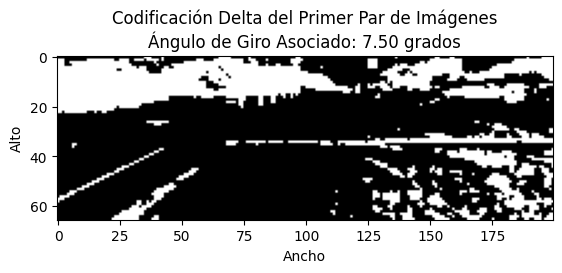

In [ ]:
import matplotlib.pyplot as plt

# Extraer el primer tensor de codificación delta
first_delta_image = train_delta_images[10]

# Extraer el primer tensor de ángulos
first_angle_tensor = train_angles[10]

# Convertir el tensor de ángulo a valor legible
def tensor_to_value(tensor):
    tensor_length = len(tensor)
    position = torch.argmax(tensor).item()
    center_position = tensor_length // 2  # Posición central (posición 11 si tensor_length es 21)
    value = (position - center_position) / center_position
    return value * 25.0  # Revertir la normalización

first_angle_value = tensor_to_value(first_angle_tensor)

# Imprimir las dimensiones del tensor y el ángulo asociado
print(f"Dimensiones del primer tensor de codificación delta: {first_delta_image.shape}")
print(f"Ángulo de giro asociado (en grados): {first_angle_value:.2f}")

# Visualizar el tensor como una imagen
plt.imshow(first_delta_image.cpu().numpy(), cmap='gray')
plt.title(f'Codificación Delta del Primer Par de Imágenes\nÁngulo de Giro Asociado: {first_angle_value:.2f} grados')
plt.xlabel('Ancho')
plt.ylabel('Alto')
plt.show()


In [ ]:
# Extraer y convertir los 20 primeros ángulos
first_20_angles = [tensor_to_value(train_angles[i]) for i in range(20)]

# Imprimir los valores de los 20 primeros ángulos
print("Los 20 primeros ángulos codificados (en grados):")
for i, angle in enumerate(first_20_angles):
    print(f"Ángulo {i+1}: {angle:.2f} grados")

# Extraer los 20 primeros tensores de ángulos
first_20_angle_tensors = train_angles[:20]

# Imprimir los 20 primeros ángulos en formato de vectores
print("Los 20 primeros ángulos codificados en formato de vectores:")
for i, angle_tensor in enumerate(first_20_angle_tensors):
    print(f"Ángulo {i+1}: {angle_tensor.cpu().numpy()}")

Los 20 primeros ángulos codificados (en grados):
Ángulo 1: 2.50 grados
Ángulo 2: 15.00 grados
Ángulo 3: -25.00 grados
Ángulo 4: -10.00 grados
Ángulo 5: 12.50 grados
Ángulo 6: 0.00 grados
Ángulo 7: 10.00 grados
Ángulo 8: 0.00 grados
Ángulo 9: 17.50 grados
Ángulo 10: -5.00 grados
Ángulo 11: 7.50 grados
Ángulo 12: 10.00 grados
Ángulo 13: 7.50 grados
Ángulo 14: 5.00 grados
Ángulo 15: -22.50 grados
Ángulo 16: -12.50 grados
Ángulo 17: 0.00 grados
Ángulo 18: 20.00 grados
Ángulo 19: -5.00 grados
Ángulo 20: 5.00 grados
Los 20 primeros ángulos codificados en formato de vectores:
Ángulo 1: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Ángulo 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Ángulo 3: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ángulo 4: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ángulo 5: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Ángulo 6: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Ángulo 7: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Ángulo 8: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0